Parsed the `crawl.log` to a series of JSON-formatted entries like:

    {
        "ip": {
            "72.52.4.119": 2
        },
        "tld": "uk",
        "virus": {},
        "host": "eastcoastribs.co.uk",
        "mime": {
            "text/html": 1,
            "text/plain": 1
        },
        "2ld": "co"
    }

A sample of which is in the file `2014.json`. The full output resides in HDFS and we use the `python-webhdfs` library to read this in.

**NOTE**: the below pulls the entire dataset from HDFS; if you want to quickly test, use the commented code that reads in `2014.json`.

## % .uk domain and non-uk

In [46]:
import json
import webhdfs
import geoip2.database
from collections import Counter
import matplotlib.pyplot as pyplot
from geoip2.errors import AddressNotFoundError
%matplotlib inline

tlds = Counter()
slds = Counter()
lat_lon = []
host_sizes = {}


def loader(source):
    reader = geoip2.database.Reader("GeoLite2-City.mmdb")
    for line in source:
        host = json.loads(line)
        tlds.update([host["tld"]])
        if "2ld" in host.keys():
            slds.update([host["2ld"]])
        #if host["tld"] == "uk":
        for ip in host["ip"].keys():
            try:
                response = reader.city(ip)
                lat_lon.append((response.location.latitude, response.location.longitude))
            except AddressNotFoundError:
                pass
        host_sizes[host["host"]] = sum(host["mime"].values())
    reader.close()

#w = webhdfs.API(prefix="http://194.66.232.90:14000/webhdfs/v1", user="heritrix")
#loader(w.readlines("/user/heritrix/2014-domain-crawl-json-formatted/", decompress=True))

with open("2014.json", "r") as i:
    loader(i)

print("Loaded.")

Loaded.


In [47]:
print("HELO")

HELO


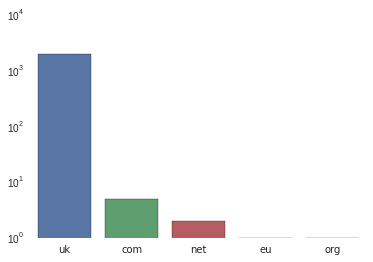

In [48]:
import pandas as pd
from collections import OrderedDict
import seaborn

for tld, count in tlds.items():
    if ":" in tld:
        val = tlds.pop(tld)
        tlds[tld.split(":")[0]] += val

tld_labels = list(tlds.keys())
tld_total = sum(list(tlds.values()))
tld_fractions = [float(value)/float(tld_total) for value in tlds.values()]
tld_explode = [1 for l in tld_labels]

tlds_sorted = OrderedDict(sorted(tlds.items(), key=lambda x: x[1], reverse=True))

#pyplot.axis("equal")
#pyplot.pie(tld_fractions, labels=tld_labels, shadow=False, explode=tld_explode, autopct="%1.1f%%")

# Plot up to 15
tldc = 15
if(len(tlds_sorted) < tldc):
    tldc = len(tlds_sorted)

seaborn.barplot(range(tldc), tlds_sorted.values()[:tldc])
pyplot.xticks(range(tldc), tlds_sorted.keys()[:tldc])
pyplot.yscale('log')
pyplot.show()


The above shows that things are very heavily skewed to `.uk` and `.com`. If we remove those...

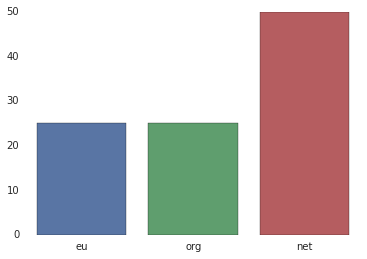

In [49]:
non_uk = tlds.copy()
non_uk.pop("uk")
non_uk.pop("com")
non_uk_tld_labels = list(non_uk.keys())
non_uk_tld_total = sum(list(non_uk.values()))
non_uk_tld_fractions = [float(value)*100/float(non_uk_tld_total) for value in non_uk.values()]
non_uk_tld_explode = [1 for l in non_uk_tld_labels]

seaborn.barplot(range(len(non_uk_tld_labels)),non_uk_tld_fractions)#labels=non_uk_tld_labels, shadow=False, explode=non_uk_tld_explode, autopct="%1.1f%%")
pyplot.xticks(range(len(non_uk_tld_labels)), non_uk_tld_labels)
pyplot.show()

In [50]:
import math

log_non_uk_tld_fractions = [math.log(float(value)/float(non_uk_tld_total)) for value in non_uk.values()]

## Type of second level domain – so what % .co.uk, .org.uk , .ac.uk etc

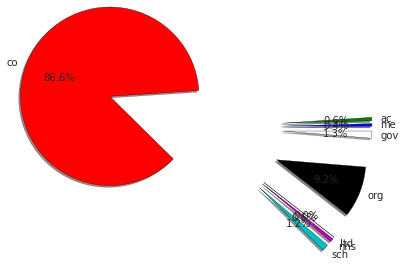

In [51]:
sld_labels = list(slds.keys())
sld_total = sum(list(slds.values()))
sld_fractions = [float(value)/float(sld_total) for value in slds.values()]
sld_explode = [1 for l in sld_labels]

pyplot.axis("equal")
pyplot.pie(sld_fractions, labels=sld_labels, shadow=True, explode=sld_explode, autopct="%1.1f%%")
pyplot.show()


## Geolocation

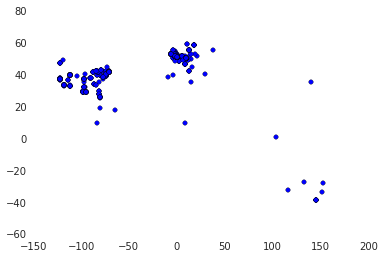

In [52]:
lat_y = [lat for lat, lon in lat_lon if lat is not None]
lon_x = [lon for lat, lon in lat_lon if lon is not None]

pyplot.scatter(lon_x, lat_y)
pyplot.show()

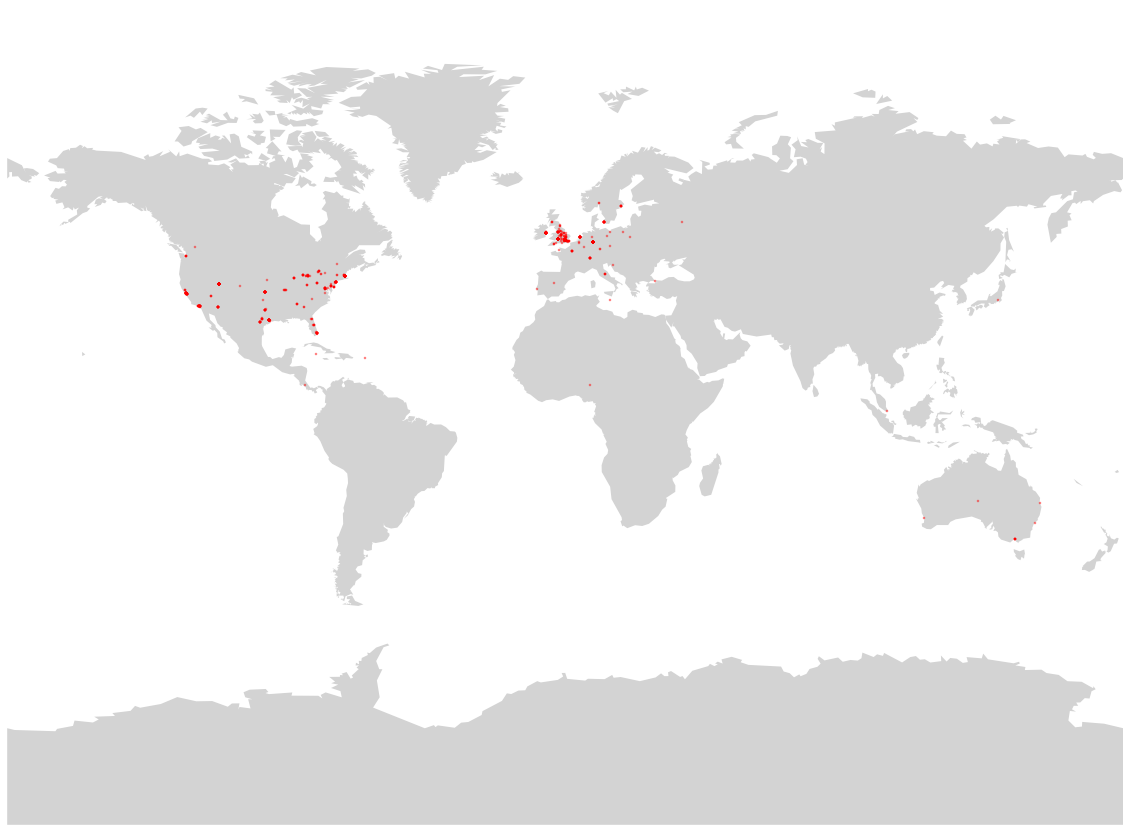

In [78]:
from mpl_toolkits.basemap import Basemap 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm

fig = plt.figure(figsize=(20,16))

m = Basemap(projection='mill',lon_0=0)
#m = Basemap(llcrnrlon=-8.0,llcrnrlat=54.5,urcrnrlon=1.5,urcrnrlat=59.5,lat_ts=20,
#            resolution='h',projection='merc',lon_0=-4.36,lat_0=54.5)

#m.drawcoastlines(color='gray')
#m.drawcountries(color='gray')
m.fillcontinents(color='lightgrey')
#m.drawmapboundary(fill_color='white') # fill to edge
#m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0]) # draw parallels
#m.drawmeridians(np.arange(0.,420.,60.),labels=[0,0,0,1]) # draw meridians

x1,y1=m(lon_x,lat_y)
#m.scatter(x1,y1,s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
m.plot(x1,y1, 'r.', markersize=5, alpha=0.5)

plt.savefig('ldwa-map-2015.png', bbox_inches='tight', dpi=150)
plt.savefig('ldwa-map-2015.pdf', bbox_inches='tight')

plt.show()

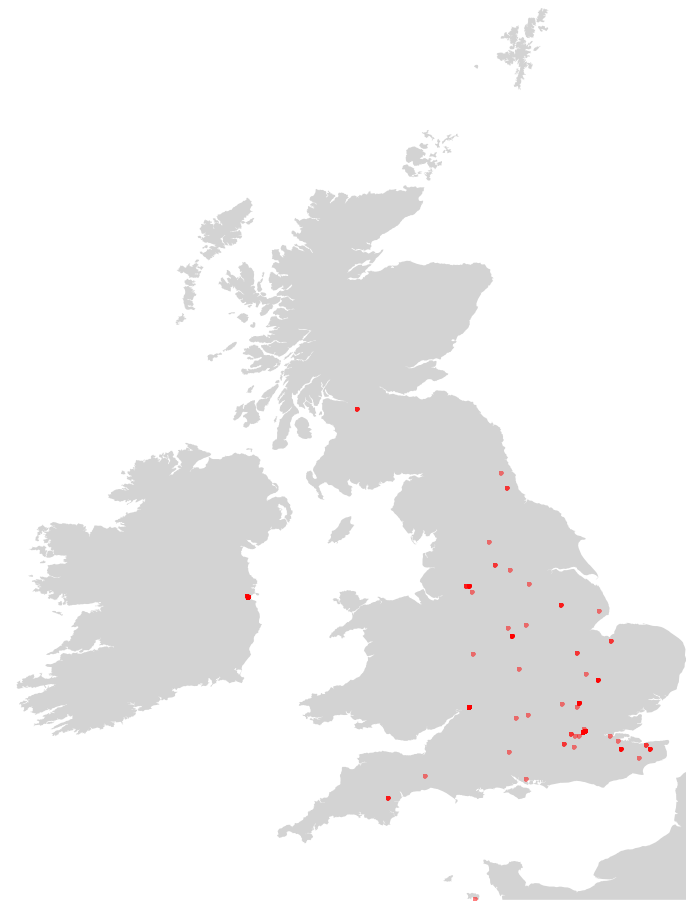

In [79]:
# Set up a UK bounding box:
bbox = {
  'lon': -5.23636,
  'lat': 53.866772,
  'll_lon': -10.65073,
  'll_lat': 49.16209,
  'ur_lon': 1.76334,
  'ur_lat': 60.860699
}

fig = plt.figure(figsize=(20,16))

m = Basemap(
  projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
  llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
  urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'], resolution='h')

#m.drawcoastlines(color='gray')
#m.drawcountries(color='gray')
m.fillcontinents(color='lightgrey')

x1,y1=m(lon_x,lat_y)
#m.scatter(x1,y1,s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
m.plot(x1,y1, 'r.', markersize=10, alpha=0.5)

plt.savefig('ldwa-uk-map-2015.png', bbox_inches='tight', dpi=150)
plt.savefig('ldwa-uk-map-2015.pdf', bbox_inches='tight')

plt.show()

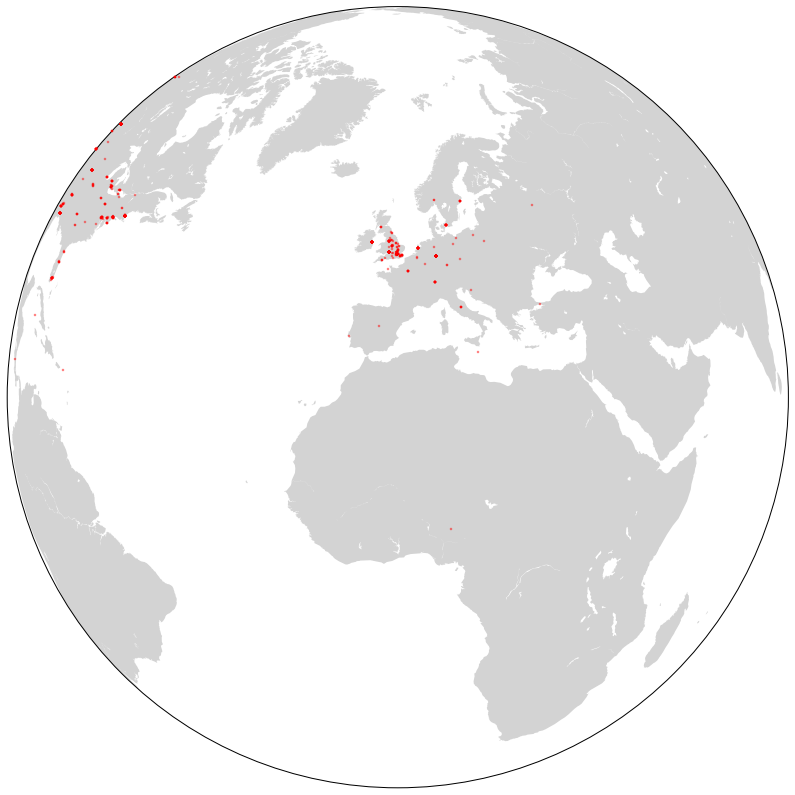

In [66]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(14,14))

# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
map = Basemap(projection='ortho', lat_0=30, lon_0=0,
              resolution='l', area_thresh=1000.0)
 
#map.drawcoastlines(color='gray', linewidth=0.25)
#map.drawcountries(linewidth=0.25)
map.fillcontinents(color='lightgrey',lake_color='white')
# draw the edge of the map projection region (the projection limb)
#map.drawmapboundary(fill_color='aqua')

x,y = map(lon_x,lat_y)
map.plot(x, y, 'r.', markersize=5, alpha=0.5)


plt.show()

## Largest sites in terms of no. of pages.

In [55]:
hosts_by_size = sorted(host_sizes.items(), key=lambda x:x[1])[-20:]
hosts_by_size.reverse()
print "\n".join([host for (host, size) in hosts_by_size])

digitalimage.co.uk
disused-stations.org.uk
downside.co.uk
doudar.co.uk
dress4play.co.uk
duchy.devon.sch.uk
dore.sheffield.sch.uk
dvdmonamour.co.uk
directtropicalfish.co.uk
discopop.co.uk
easternroses.co.uk
ducklingsmontessori.co.uk
earthmothersoulsister.co.uk
eafa.org.uk
duckettsplastering.co.uk
drumlanrig-st-cuthberts.scotborders.sch.uk
e-lawresources.co.uk
downhamonline.org.uk
earlyenglishlaws.ac.uk
dockmuseum.org.uk
